<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# Train Detectron2 On Custom Dentex Dataset.

`Detectron2`, a popular open-source object detection library developed by Facebook AI Research `(FAIR)`, offers state-of-the-art solutions for training and deploying computer vision models. In this notebook, we will delve into the process of training Detectron2 on a custom dataset focused on dentex, a species of fish known for its distinct features.

To train our object detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Object detection dataset from Roboflow
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Dectron2 performance
* Run Detectron2 inference on test images
* Export saved Detectron2 weights for future inference


## Before you start
Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator and set it to GPU.

In [1]:
!nvidia-smi

Mon Apr 22 06:09:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting `HOME` Directory

In [3]:
HOME = "/content/drive/MyDrive/Detectron"
%cd {HOME}

/content/drive/MyDrive/Detectron


# Install Roboflow and Detectron2 Pip Packages, Import Deps

In [4]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

In [5]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

# Download dataset via Roboflow pip package and show a sample annotation

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="OpapqhOjAxGKCYdPz0oZ")
project = rf.workspace("dentex-challenge-2023").project("dentex-dataset")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dentex-dataset-1 in coco:: 100%|██████████| 711/711 [00:09<00:00, 78.55it/s]


In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train_1", {}, "/content/drive/MyDrive/Detectron/dentex-dataset-1/train/_annotations.coco.json", "/content/drive/MyDrive/Detectron/dentex-dataset-1/train")
register_coco_instances("my_dataset_val_1", {}, "/content/drive/MyDrive/Detectron/dentex-dataset-1/valid/_annotations.coco.json", "/content/drive/MyDrive/Detectron/dentex-dataset-1/valid")
# register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

/content/drive/MyDrive/Detectron
WARNING [04/22 06:16:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 06:16:23 d2.data.datasets.coco]: Loaded 566 images in COCO format from /content/drive/MyDrive/Detectron/dentex-dataset-1/train/_annotations.coco.json


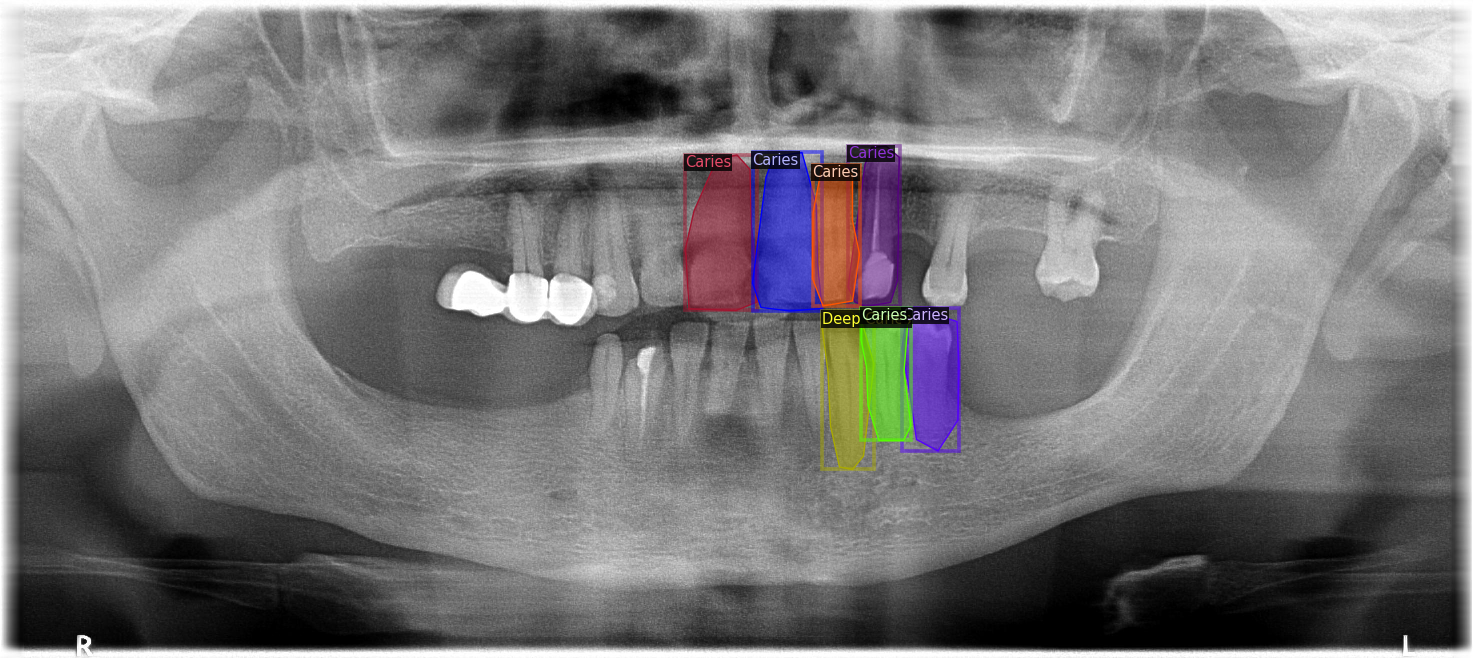

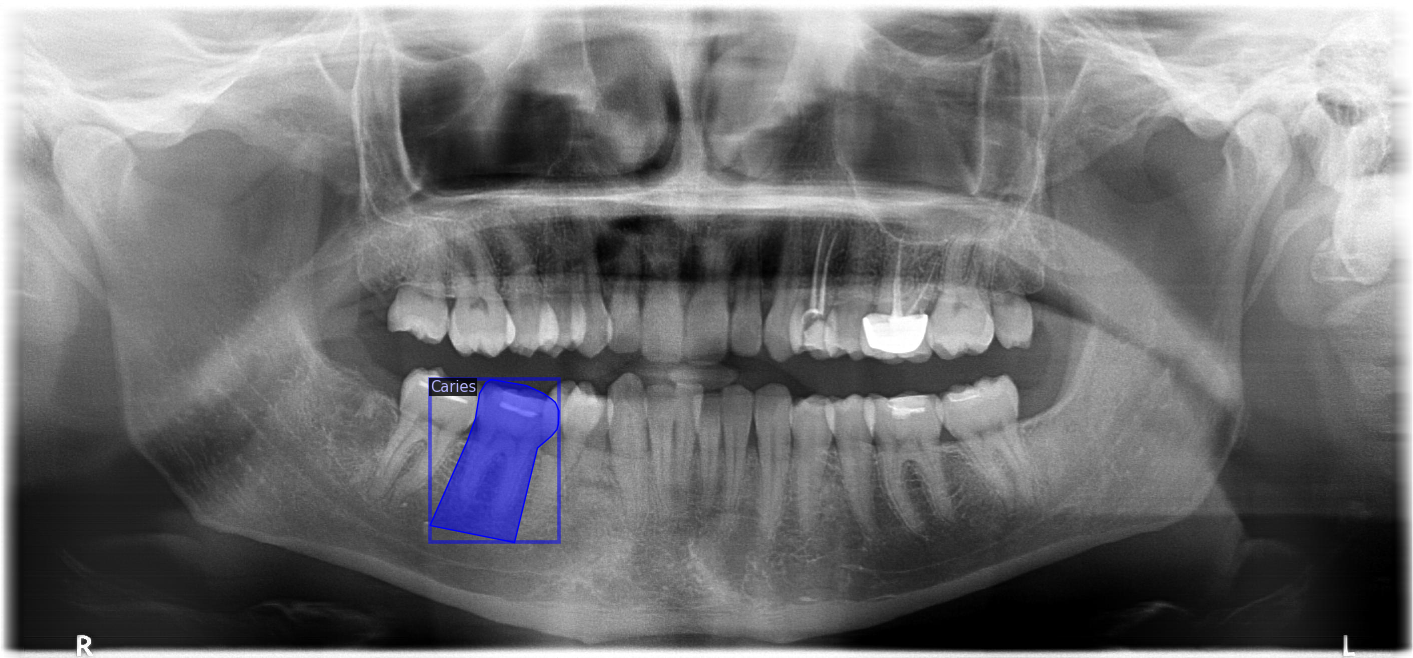

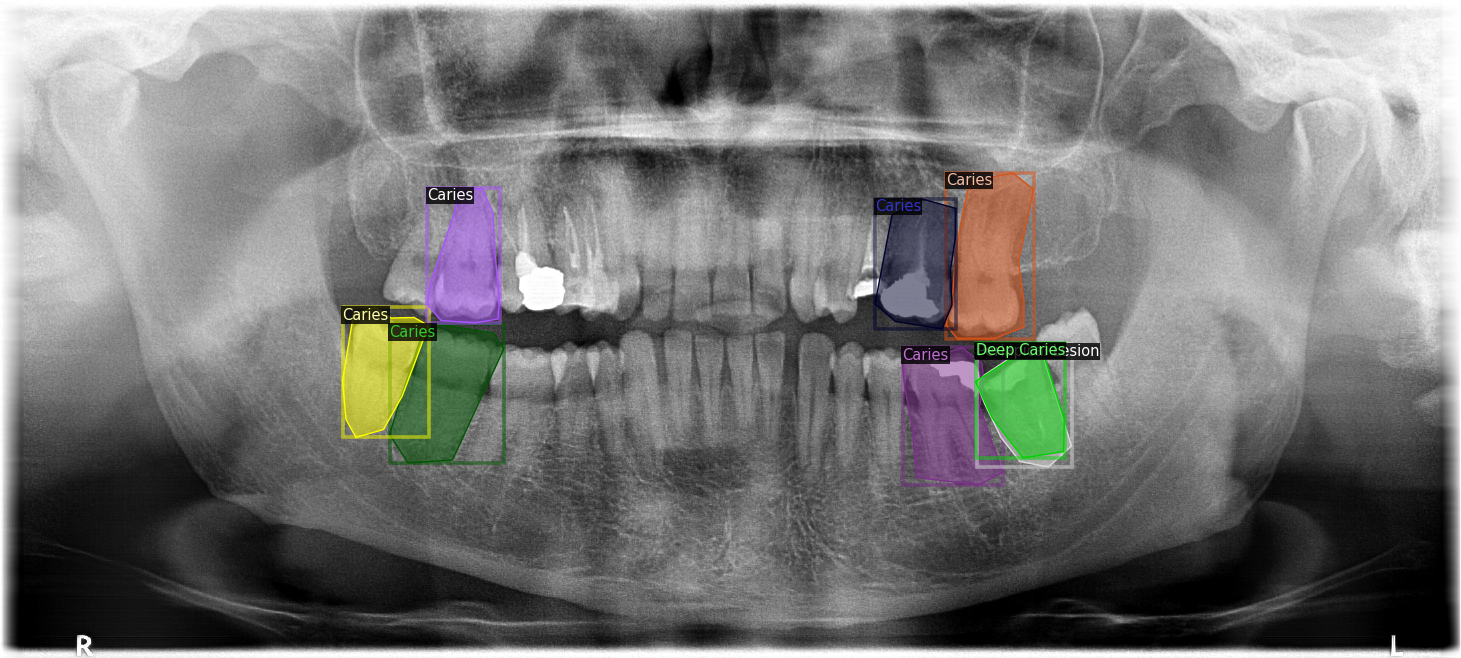

In [9]:
%cd {HOME}
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train_1")
dataset_dicts = DatasetCatalog.get("my_dataset_train_1")

import random
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Visualize training data

# Write our Detectron2 training configuration

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train_1",)
cfg.DATASETS.TEST = ("my_dataset_val_1",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

cfg.TEST.EVAL_PERIOD = 500

# Run Detectron2 training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/01 07:39:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:04, 89.1MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/01 07:39:58 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


[04/01 07:41:30 d2.utils.events]:  eta: 2:23:42  iter: 19  total_loss: 2.594  loss_cls: 1.492  loss_box_reg: 0.4875  loss_rpn_cls: 0.5132  loss_rpn_loc: 0.043    time: 4.3210  last_time: 4.0081  data_time: 0.0709  last_data_time: 0.0108   lr: 1.931e-06  max_mem: 10548M
[04/01 07:43:00 d2.utils.events]:  eta: 2:22:40  iter: 39  total_loss: 2.414  loss_cls: 1.459  loss_box_reg: 0.5583  loss_rpn_cls: 0.3591  loss_rpn_loc: 0.03549    time: 4.3411  last_time: 4.4343  data_time: 0.0217  last_data_time: 0.0653   lr: 2.911e-06  max_mem: 11320M
[04/01 07:44:28 d2.utils.events]:  eta: 2:21:35  iter: 59  total_loss: 2.268  loss_cls: 1.406  loss_box_reg: 0.5789  loss_rpn_cls: 0.2456  loss_rpn_loc: 0.03852    time: 4.3662  last_time: 4.2309  data_time: 0.0225  last_data_time: 0.0126   lr: 3.891e-06  max_mem: 11321M
[04/01 07:45:55 d2.utils.events]:  eta: 2:20:05  iter: 79  total_loss: 2.324  loss_cls: 1.369  loss_box_reg: 0.6925  loss_rpn_cls: 0.1915  loss_rpn_loc: 0.0371    time: 4.3573  last_time

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/01 08:17:41 d2.utils.events]:  eta: 1:47:52  iter: 519  total_loss: 1.547  loss_cls: 0.6354  loss_box_reg: 0.8609  loss_rpn_cls: 0.03449  loss_rpn_loc: 0.02653    time: 4.3361  last_time: 4.1071  data_time: 0.0256  last_data_time: 0.0506   lr: 2.6431e-05  max_mem: 11322M
[04/01 08:19:09 d2.utils.events]:  eta: 1:46:26  iter: 539  total_loss: 1.588  loss_cls: 0.6506  loss_box_reg: 0.8592  loss_rpn_cls: 0.03143  loss_rpn_loc: 0.02532    time: 4.3384  last_time: 4.3898  data_time: 0.0189  last_data_time: 0.0154   lr: 2.7411e-05  max_mem: 11322M
[04/01 08:20:36 d2.utils.events]:  eta: 1:44:58  iter: 559  total_loss: 1.523  loss_cls: 0.624  loss_box_reg: 0.825  loss_rpn_cls: 0.02739  loss_rpn_loc: 0.02175    time: 4.3379  last_time: 4.3691  data_time: 0.0188  last_data_time: 0.0173   lr: 2.8391e-05  max_mem: 11322M
[04/01 08:22:02 d2.utils.events]:  eta: 1:43:31  iter: 579  total_loss: 1.594  loss_cls: 0.6598  loss_box_reg: 0.8648  loss_rpn_cls: 0.03743  loss_rpn_loc: 0.023    time: 4.3

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/01 08:53:46 d2.utils.events]:  eta: 1:11:26  iter: 1019  total_loss: 1.009  loss_cls: 0.4532  loss_box_reg: 0.5203  loss_rpn_cls: 0.02169  loss_rpn_loc: 0.01865    time: 4.3321  last_time: 4.2456  data_time: 0.0209  last_data_time: 0.0121   lr: 5e-05  max_mem: 11322M
[04/01 08:55:14 d2.utils.events]:  eta: 1:09:59  iter: 1039  total_loss: 1.01  loss_cls: 0.4604  loss_box_reg: 0.5068  loss_rpn_cls: 0.01236  loss_rpn_loc: 0.01624    time: 4.3333  last_time: 4.2303  data_time: 0.0188  last_data_time: 0.0127   lr: 5e-05  max_mem: 11322M
[04/01 08:56:40 d2.utils.events]:  eta: 1:08:31  iter: 1059  total_loss: 1.026  loss_cls: 0.4712  loss_box_reg: 0.5247  loss_rpn_cls: 0.01782  loss_rpn_loc: 0.02064    time: 4.3328  last_time: 4.2304  data_time: 0.0213  last_data_time: 0.0126   lr: 5e-05  max_mem: 11322M
[04/01 08:58:06 d2.utils.events]:  eta: 1:07:03  iter: 1079  total_loss: 0.9976  loss_cls: 0.4635  loss_box_reg: 0.4778  loss_rpn_cls: 0.01942  loss_rpn_loc: 0.01599    time: 4.3321  la

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/01 09:29:52 d2.utils.events]:  eta: 0:35:00  iter: 1519  total_loss: 0.8479  loss_cls: 0.4147  loss_box_reg: 0.411  loss_rpn_cls: 0.01187  loss_rpn_loc: 0.02039    time: 4.3322  last_time: 4.3766  data_time: 0.0213  last_data_time: 0.0146   lr: 2.5e-06  max_mem: 11322M
[04/01 09:31:20 d2.utils.events]:  eta: 0:33:33  iter: 1539  total_loss: 0.8452  loss_cls: 0.4169  loss_box_reg: 0.3592  loss_rpn_cls: 0.01624  loss_rpn_loc: 0.01505    time: 4.3327  last_time: 4.0529  data_time: 0.0187  last_data_time: 0.0147   lr: 2.5e-06  max_mem: 11322M
[04/01 09:32:46 d2.utils.events]:  eta: 0:32:05  iter: 1559  total_loss: 0.7812  loss_cls: 0.3954  loss_box_reg: 0.356  loss_rpn_cls: 0.008997  loss_rpn_loc: 0.01546    time: 4.3327  last_time: 4.3904  data_time: 0.0191  last_data_time: 0.0146   lr: 2.5e-06  max_mem: 11322M
[04/01 09:34:13 d2.utils.events]:  eta: 0:30:38  iter: 1579  total_loss: 0.8078  loss_cls: 0.4244  loss_box_reg: 0.36  loss_rpn_cls: 0.01141  loss_rpn_loc: 0.01481    time: 4.3

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


# Evaluate Detectron2 performance

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_val_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val_1")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/01 10:09:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [04/01 10:09:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/01 10:09:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/01 10:09:56 d2.data.datasets.coco]: Loaded 139 images in COCO format from /content/drive/MyDrive/Detectron/dentex-dataset-1/valid/_annotations.coco.json
[04/01 10:09:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/01 10:09:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/01 10:09:56 d2.data.common]: Serializing 139 elements to byte tensors and concatenating them all ...
[04/01 10:09:5

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[04/01 10:10:02 d2.evaluation.evaluator]: Inference done 11/139. Dataloading: 0.0018 s/iter. Inference: 0.2548 s/iter. Eval: 0.0004 s/iter. Total: 0.2569 s/iter. ETA=0:00:32
[04/01 10:10:07 d2.evaluation.evaluator]: Inference done 33/139. Dataloading: 0.0032 s/iter. Inference: 0.2369 s/iter. Eval: 0.0004 s/iter. Total: 0.2408 s/iter. ETA=0:00:25
[04/01 10:10:12 d2.evaluation.evaluator]: Inference done 53/139. Dataloading: 0.0047 s/iter. Inference: 0.2403 s/iter. Eval: 0.0005 s/iter. Total: 0.2458 s/iter. ETA=0:00:21
[04/01 10:10:17 d2.evaluation.evaluator]: Inference done 74/139. Dataloading: 0.0043 s/iter. Inference: 0.2397 s/iter. Eval: 0.0005 s/iter. Total: 0.2448 s/iter. ETA=0:00:15
[04/01 10:10:22 d2.evaluation.evaluator]: Inference done 96/139. Dataloading: 0.0038 s/iter. Inference: 0.2384 s/iter. Eval: 0.0005 s/iter. Total: 0.2429 s/iter. ETA=0:00:10
[04/01 10:10:27 d2.evaluation.evaluator]: Inference done 115/139. Dataloading: 0.0045 s/iter. Inference: 0.2416 s/iter. Eval: 0.00

OrderedDict([('bbox',
              {'AP': 17.01034287142322,
               'AP50': 28.603610816577806,
               'AP75': 19.11070402452263,
               'APs': nan,
               'APm': 0.0,
               'APl': 17.0232222782826,
               'AP-disease': nan,
               'AP-Caries': 19.757893651950347,
               'AP-Deep Caries': 4.906526097262553,
               'AP-Impacted': 43.376951736479974,
               'AP-Periapical Lesion': 0.0})])

# Test model and show example output

[04/22 06:19:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


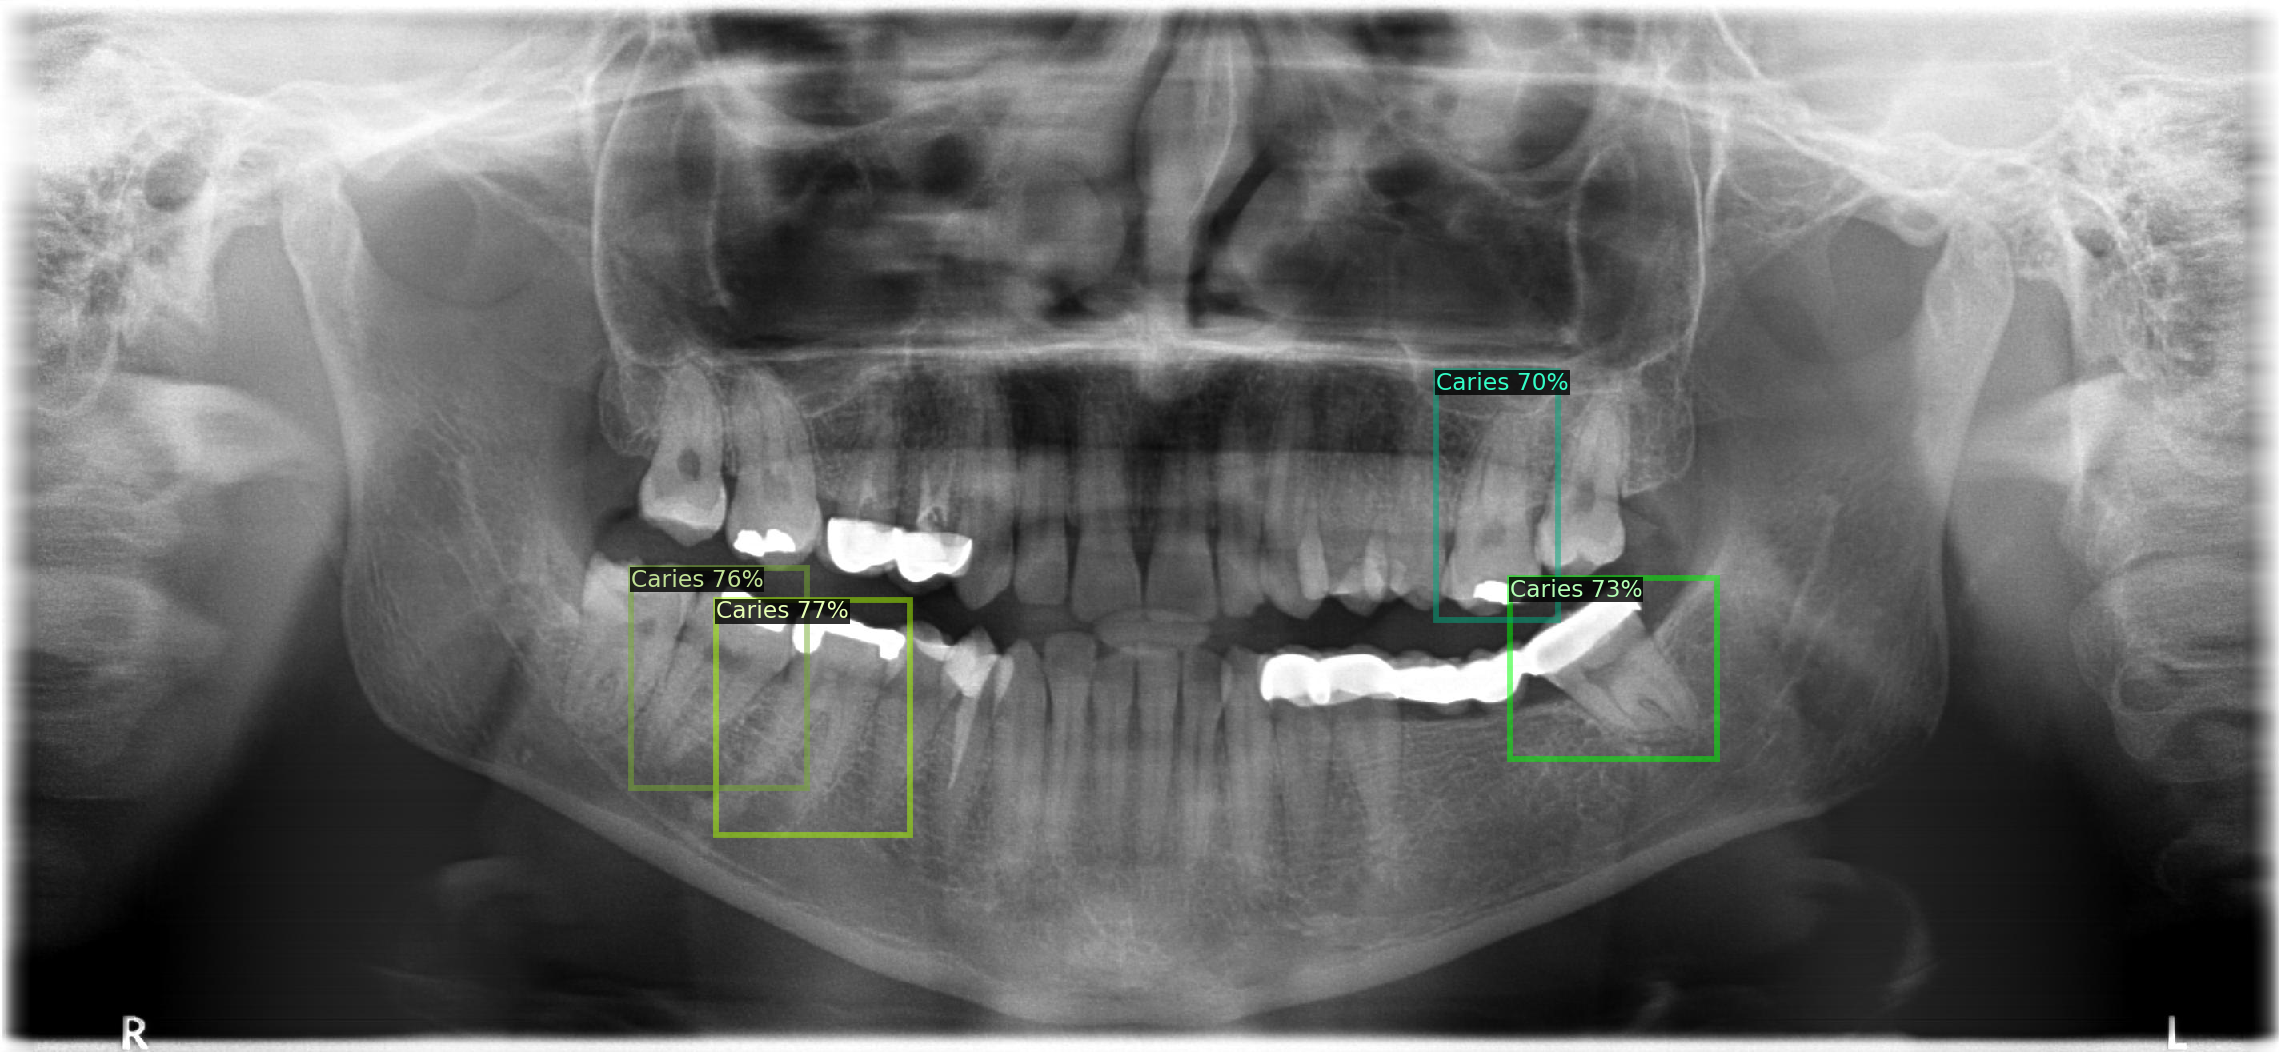

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_val_1", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_val_1")

from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/drive/MyDrive/Detectron/dentex-dataset-1/valid/train_0_png.rf.b46543dd5d0fe4f45adb49d1f23a6bc2.jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

# Download trained model for future inference

In [ ]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>